In [1]:
import pandas as pd
import numpy as np
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [2]:
df_temp_out = pd.read_csv('outdoor_temperature.csv')  
df_temp_in = pd.read_csv('indoor_temperature.csv')  
df_cool = pd.read_csv('cooling_consumption.csv')  

df_combined = pd.concat([df_temp_out, df_temp_in, df_cool], axis=1)  
date_range = pd.date_range(start='2021-01-01', end='2022-12-28', freq='D')
df_combined['date'] = date_range
print(df_combined)

     5.2000  4.2000  4.4000  3.3000  1.7000  2.8000  1.9000  1.9000.1  2.0000  \
0       0.9     1.4     1.6     0.8    -0.4    -1.1    -1.2      -0.7    -0.7   
1       0.8     0.9     0.9     1.1     1.3     1.3     0.1      -0.6     1.9   
2       0.5     0.2     0.1     0.6     0.3    -0.4    -0.4       0.1     0.8   
3       1.9     1.7     1.3     1.5     1.5     1.3     1.0       0.9     1.1   
4       1.4     1.5     1.5     1.5     1.4     1.5     1.5       1.4     1.7   
..      ...     ...     ...     ...     ...     ...     ...       ...     ...   
722     7.1     7.2     7.6    10.5    11.7     8.5     7.7       8.0    11.0   
723     8.1     7.8     6.9     7.0     5.8     7.8     6.5       7.5     9.1   
724    10.9    11.0    10.7    10.9    10.9    10.6    10.5      10.7    11.0   
725     6.5     6.9     6.3     5.8     4.9     4.8     4.0       5.1     7.3   
726     9.3     8.9     8.7     8.7     9.2     9.1    10.3       9.1     9.8   

     2.3000  ...  0.0000.15

In [3]:
df_no_cooling = df_combined[df_combined.iloc[:, -25:-1].sum(axis=1) == 0]  
df_cooling = df_combined[df_combined.iloc[:, -25:-1].sum(axis=1) != 0]      

df_cooling = df_cooling.reset_index(drop=True)

print(df_cooling)


     5.2000  4.2000  4.4000  3.3000  1.7000  2.8000  1.9000  1.9000.1  2.0000  \
0      13.7    13.4    13.3    13.3    13.4    13.5    14.3      14.7    13.9   
1      13.9    13.5    12.0    11.8    11.6    11.9    12.7      13.8    17.0   
2      10.2    10.0    10.0     9.8    10.1    10.6    10.8      10.1    10.1   
3       6.7     6.3     5.9     6.4     7.5     8.4     9.5      11.4    13.7   
4      10.6    10.9    11.0    11.1    11.1    11.5    12.3      13.2    15.3   
..      ...     ...     ...     ...     ...     ...     ...       ...     ...   
192    17.8    17.8    17.9    17.9    17.9    17.9    18.2      19.2    21.4   
193    19.3    19.4    19.4    19.3    19.2    19.0    19.1      19.7    20.6   
194     8.0     7.6     7.0     6.1     5.3     5.1     5.2       7.8    11.6   
195    15.4    15.2    14.5    13.0    13.8    14.5    15.1      17.0    18.7   
196    11.7    10.4     9.3     8.9     8.8     8.9     9.2       9.1     9.2   

     2.3000  ...  0.0000.15

In [7]:
cooling_indices = df_cooling.index
#print(heating_indices)
df_temp_out_cooling = df_temp_out.iloc[cooling_indices]
df_temp_in_cooling = df_temp_in.iloc[cooling_indices]
df_cool_cooling = df_cool.iloc[cooling_indices]

#print(df_temp_out_cooling)
#print(df_temp_in_cooling)
#print(df_cool_cooling)

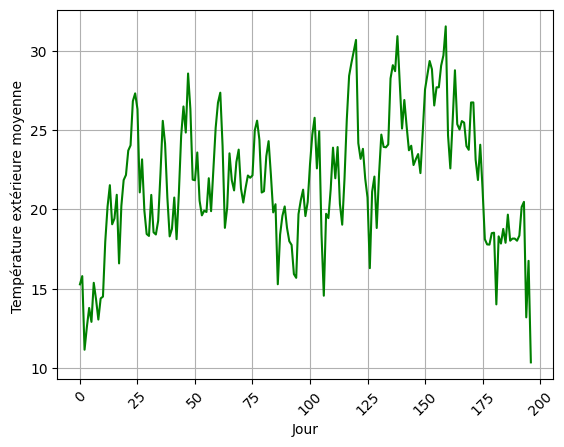

In [20]:
external_temp_columns = df_cooling.columns[:24]
cooling_days_avg_temp = df_cooling[external_temp_columns].mean(axis=1)
plt.plot(df_cooling.index, cooling_days_avg_temp, linestyle='-', color='g')
plt.xlabel('Jour')
plt.ylabel('Température extérieure moyenne ')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

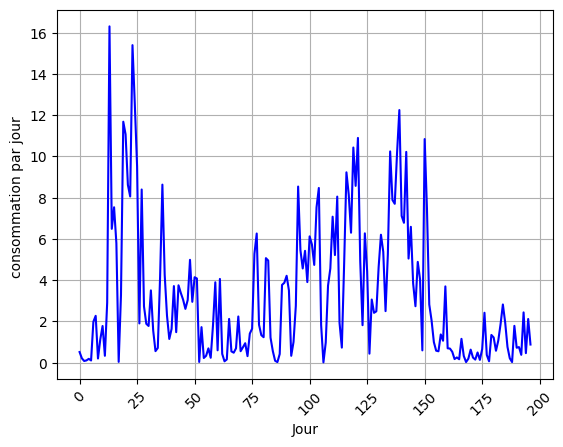

In [5]:

sums_last_24 = df_cooling.iloc[:, -24:-1].sum(axis=1)

plt.plot(df_cooling.index, sums_last_24, linestyle='-', color='b')
plt.xlabel('Jour')
plt.ylabel('consommation par jour ')
plt.grid(True)
plt.xticks(rotation=45) 
plt.show()


In [8]:
def normalize_data(data):
    scaler = TimeSeriesScalerMeanVariance()
    data_normalized = scaler.fit_transform(data.values.reshape((data.shape[0], data.shape[1], 1)))
    return pd.DataFrame(data_normalized.reshape(data_normalized.shape[0], data_normalized.shape[1]), columns=data.columns)


In [9]:

def apply_kmeans(data,data_normalized, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data_normalized['cluster'] = kmeans.fit_predict(data_normalized)
    data['cluster']=data_normalized['cluster']
    return kmeans, data


In [11]:
df_cooling2=df_cooling.drop(columns=["date"])
df_normalized = normalize_data(df_cooling2)

kmeans, data_normalized_with_cluster = apply_kmeans(df_cooling2,df_normalized, 4)


df_cooling["cluster"]=data_normalized_with_cluster["cluster"]
df_cool_cooling.loc[:, "cluster"] = data_normalized_with_cluster["cluster"]
df_temp_in_cooling.loc[:, "cluster"] = data_normalized_with_cluster["cluster"]
df_temp_out_cooling.loc[:, "cluster"] = data_normalized_with_cluster["cluster"]


In [12]:
def compute_cluster_means(data_normalized, cluster_assignments, column_index):
    cluster_means = {}

    for cluster_id in np.unique(cluster_assignments):
        cluster_data = data_normalized[cluster_assignments == cluster_id].iloc[:, column_index:-1]
        cluster_means[cluster_id] = cluster_data.mean(axis=0)  

    return cluster_means


In [13]:
def plot_clusters_single_variable(data_normalized, cluster_assignments, column_index, y_label="Valeur", num_labels=10):
    cluster_means = compute_cluster_means(data_normalized, cluster_assignments, column_index)

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    all_values = []
    for cluster_id, cluster_center in cluster_means.items():
        cluster_data = data_normalized[cluster_assignments == cluster_id].iloc[:, column_index:-1]
        all_values.extend(cluster_data.values.flatten())  
    y_min = np.min(all_values)
    y_max = np.max(all_values)

    for cluster_id, cluster_center in cluster_means.items():
        cluster_data = data_normalized[cluster_assignments == cluster_id].iloc[:, column_index:-1]

        for idx, row in cluster_data.iterrows():
            axes[cluster_id // 2, cluster_id % 2].plot(range(24), row, color='gray', alpha=0.5)
        
        axes[cluster_id // 2, cluster_id % 2].plot(range(24), cluster_center, color='red', linewidth=3, label=f"Centre du cluster {cluster_id}")
        
        axes[cluster_id // 2, cluster_id % 2].set_title(f"Séries temporelles du Cluster {cluster_id}")
        axes[cluster_id // 2, cluster_id % 2].set_xlabel("Heures")
        axes[cluster_id // 2, cluster_id % 2].set_ylabel(y_label)
        
        axes[cluster_id // 2, cluster_id % 2].set_ylim([y_min, y_max])
        axes[cluster_id // 2, cluster_id % 2].grid(True)

    plt.tight_layout()
    plt.show()

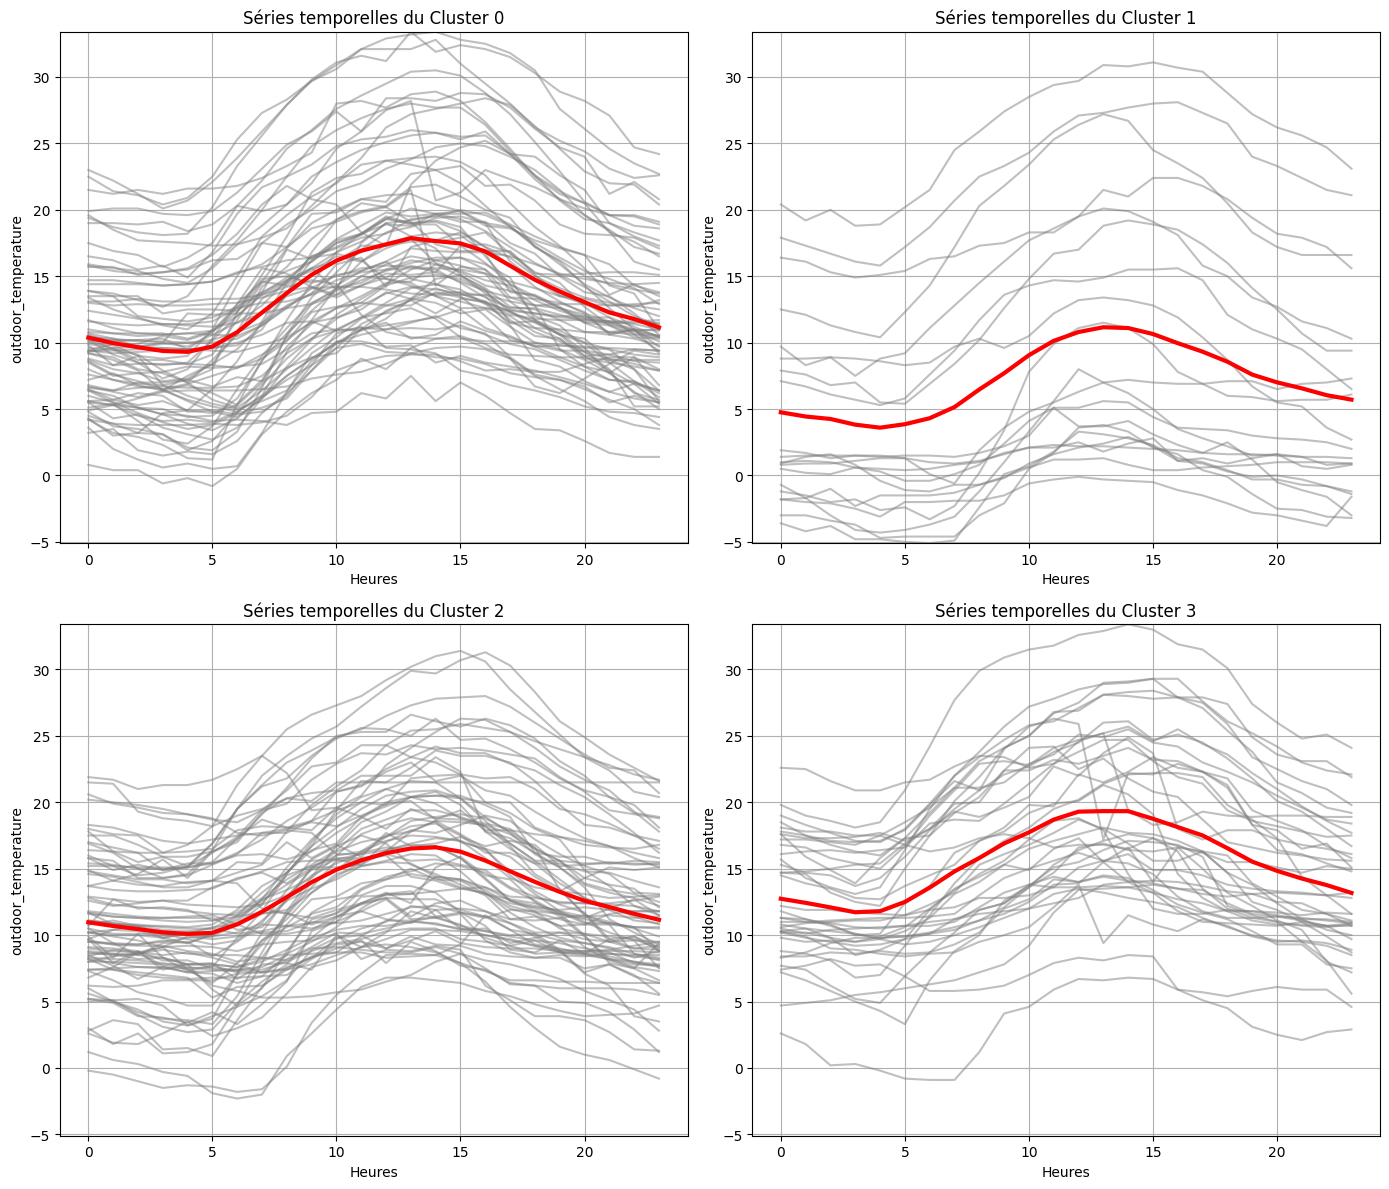

In [14]:
plot_clusters_single_variable(df_temp_out_cooling, df_temp_out_cooling["cluster"], column_index=0, y_label="outdoor_temperature")
